In [39]:
from tensorflow import keras

import numpy as np

import pandas as pd

import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Bert-as-client')
from utils import simple_process, clean_text, lemmatization, normalize_and_scale

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import pickle
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import layers
from keras import callbacks

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)   

Mounted at /content/gdrive


In [2]:
def load_data():
    # load the imdb dataset into a dataframe

    df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Bert-as-client/IMDB Dataset.csv')
    num_samples = df.shape[0]
    return df, num_samples

In [3]:
def pre_process_data(text):
    # pre-process the texts
    
    text = clean_text(text)
    text = simple_process(text)
    text = lemmatization(text)

    return text

In [4]:
df, num_samples = load_data()
print(df.head(10))
print("\nNumber of samples = ", num_samples)
print("Unique labels : ", df['sentiment'].unique())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive
6  I sure would like to see a resurrection of a u...  positive
7  This show was an amazing, fresh & innovative i...  negative
8  Encouraged by the positive comments about this...  negative
9  If you like original gut wrenching laughter yo...  positive

Number of samples =  50000
Unique labels :  ['positive' 'negative']


In [5]:
def process_reviews(df):
    for i in tqdm(range(num_samples)):
        df['review'][i] = pre_process_data(df['review'][i])
        if (df['sentiment'][i]=='positive'):
            df['sentiment'][i] = 1
        else:
            df['sentiment'][i] = 0

    return df

In [ ]:
# This might take a lot of time to complete
df = process_reviews(df)
df.head(10)

In [36]:
df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Bert-as-client/pre_processed_IMDB Dataset.csv', index=False)

In [6]:
df= pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Bert-as-client/pre_processed_IMDB Dataset.csv')
df

,review,sentiment
0,other reviewer mention watch just episode will...,1
1,wonderful little production filming technique ...,1
2,think wonderful way spend time too hot summer ...,1
3,basically family where little boy jake think z...,0
4,petter mattei love time money visually stunnin...,1
...,...,...
49995,think movie right good job as creative origina...,1
49996,bad plot bad dialogue bad act idiotic direct a...,0
49997,teach parochial elementary school nun teach pr...,0
49998,go disagree previous comment side one second r...,0


In [21]:
# split into training and validation sets
train, test = train_test_split(df, random_state=42, test_size=0.30)

X_train = train.review
X_test  = test.review
y_train = train.drop(labels = ['review'], axis=1)
y_test  = test.drop(labels = ['review'], axis=1)

In [8]:
X_train

38094    as much love train could stomach movie premise...
40624    very good wrestlemania year later wwe cram so ...
49425    find right word problem type urban comedy know...
35734    really suprise movie high rating imdb movie co...
41708    will start confess tend really enjoy action mo...
                               ...                        
11284    magic recapture joy amazement first movie audi...
44732    find movie quite enjoyable fairly entertain go...
38158    avoid one terrible movie so very exciting just...
860      production quite surprise absolutely love obsc...
15795    decent movie little bit short time pack lot ac...
Name: review, Length: 35000, dtype: object

In [22]:
y_train


,sentiment
38094,0
40624,1
49425,0
35734,1
41708,0
...,...
11284,1
44732,1
38158,0
860,1


In [3]:
pip install tensorflow==1.15

     |████████████████████████████████| 412.3 MB 18 kB/s 
     |████████████████████████████████| 503 kB 45.7 MB/s 
     |████████████████████████████████| 50 kB 8.7 MB/s 
     |████████████████████████████████| 3.8 MB 30.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7553 sha256=af7f0bf2206a772d03d002bc7b1926245403169c398e1c3f100df2cac2db9b83
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [11]:
pip install -U bert-serving-server bert-serving-client

     |████████████████████████████████| 61 kB 313 kB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7410 sha256=cbdb39ce7fc41c877a812fd5fcd21cf9619a3ed5c5fba21d14b2f8db19f26871
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil


In [12]:
def setup_bert_client():
    !wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip && unzip uncased_L-12_H-768_A-12.zip
    !nohup bert-serving-start -model_dir uncased_L-12_H-768_A-12/ -num_worker=2 -max_seq_len 512 > out.file 2>&1 &

In [13]:
def sentence_embedding():

    from bert_serving.client import BertClient

    X_train_bert = []
    X_test_bert = []

    bc = BertClient()

    for i in tqdm(range(35000)):
        temp = bc.encode(X_train[i:i+1].to_list())
        X_train_bert.append(temp[0])

    for i in tqdm(range(15000)):
        temp = bc.encode(X_test[i:i+1].to_list())
        X_test_bert.append(temp[0])

    X_test_bert = np.array(X_test_bert)
    X_train_bert = np.array(X_train_bert)

    with open('/content/gdrive/MyDrive/Colab Notebooks/Bert-as-client/trainBERTSentenceEmbeddings.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(X_train_bert, filehandle)

    with open('/content/gdrive/MyDrive/Colab Notebooks/Bert-as-client/testBERTSentenceEmbeddings.data', 'wb') as filehandle:
        # store the data as binary data stream
        pickle.dump(X_test_bert, filehandle)

In [14]:
setup_bert_client()

--2021-07-26 13:38:38--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   295MB/s    in 1.3s    

2021-07-26 13:38:39 (295 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [15]:
sentence_embedding()

/usr/local/lib/python3.7/dist-packages/bert_serving/client/__init__.py:299: UserWarning: some of your sentences have more tokens than "max_seq_len=512" set on the server, as consequence you may get less-accurate or truncated embeddings.
here is what you can do:
- disable the length-check by create a new "BertClient(check_length=False)" when you do not want to display this warning
- or, start a new server with a larger "max_seq_len"
  '- or, start a new server with a larger "max_seq_len"' % self.length_limit)


In [23]:
def load_sentence_embeddings():
    with open('/content/gdrive/MyDrive/Colab Notebooks/Bert-as-client/trainBERTSentenceEmbeddings.data', 'rb') as filehandle:
        # read the data as binary data stream
        X_train_bert = pickle.load(filehandle)

    with open('/content/gdrive/MyDrive/Colab Notebooks/Bert-as-client/testBERTSentenceEmbeddings.data', 'rb') as filehandle:
        # store the data as binary data stream
        X_val_bert = pickle.load(filehandle)
    
    return X_train_bert, X_val_bert

In [24]:
X_train, X_test = load_sentence_embeddings()

In [25]:
X_train, X_test = normalize_and_scale(X_train, X_test)

In [48]:
def create_model(X_train):
    input_dim = X_train.shape[1]  # Number of features

    model = Sequential()
    model.add(layers.Dense(512, input_dim=input_dim, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, input_dim=input_dim, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, input_dim=input_dim, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, input_dim=input_dim, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # activation = {sigmoid (for multi-label) ; softmax (for multi-class)} 

    # use binary_crossentropy for multi-label classification (classify more than one topics per document)
    # use categorical_crossentropy for multi-class classification (classify one topic per document)
    model.compile(loss='binary_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    
    return model

In [49]:
model = create_model(X_train)
earlyStopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=12)
modelCheckpoint = callbacks.ModelCheckpoint('/content/gdrive/MyDrive/Colab Notebooks/bert_serving_client_classification_model.hdf5',
                                            save_best_only=True, monitor='val_accuracy', mode='max')
#reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,patience=10, min_lr=0.001)
history = model.fit(X_train, y_train,
                    epochs=80,
                    validation_data=(X_test, y_test),
                    batch_size=2000, callbacks=[earlyStopping,modelCheckpoint])

Epoch 1/80
18/18 [==============================] - 6s 252ms/step - loss: 0.7939 - accuracy: 0.5656 - val_loss: 0.4664 - val_accuracy: 0.7855
Epoch 2/80
18/18 [==============================] - 4s 206ms/step - loss: 0.4736 - accuracy: 0.7880 - val_loss: 0.4239 - val_accuracy: 0.8197
Epoch 3/80
18/18 [==============================] - 4s 207ms/step - loss: 0.4141 - accuracy: 0.8170 - val_loss: 0.3822 - val_accuracy: 0.8327
Epoch 4/80
18/18 [==============================] - 4s 203ms/step - loss: 0.3950 - accuracy: 0.8246 - val_loss: 0.3709 - val_accuracy: 0.8387
Epoch 5/80
18/18 [==============================] - 4s 200ms/step - loss: 0.3760 - accuracy: 0.8350 - val_loss: 0.3706 - val_accuracy: 0.8413
Epoch 6/80
18/18 [==============================] - 4s 201ms/step - loss: 0.3662 - accuracy: 0.8384 - val_loss: 0.3621 - val_accuracy: 0.8448
Epoch 7/80
18/18 [==============================] - 4s 205ms/step - loss: 0.3570 - accuracy: 0.8435 - val_loss: 0.3618 - val_accuracy: 0.8466
Epoch 

In [50]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


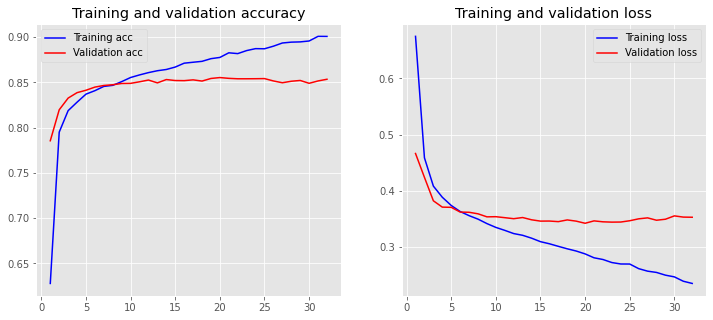

In [51]:
plot_history(history)

In [52]:
print(np.round(model.predict(X_test)[0:4]))
print(y_test[0:4])

[[1.]
 [1.]
 [0.]
 [1.]]
       sentiment
33553          1
9427           1
199            0
12447          1
